<a href="https://colab.research.google.com/github/RockhoRockho/Deep_Learning/blob/main/_10_4_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_RNN_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치 RNN 분류 모델
- 코드 출처: https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

In [1]:
!wget http://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-12-17 06:38:45--  http://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.36, 13.226.52.51, 13.226.52.128, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  10.6MB/s    in 0.3s    

2021-12-17 06:38:46 (10.6 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian

이름: Ślusàrski

In [5]:
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt']
Slusarski


In [8]:
print(category_lines['French'][:5])

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


In [10]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

## 신경망 생성

- 모델 생성 방법 참고 : https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

In [12]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output, next_hidden)

tensor([[-2.8164, -2.9995, -2.8425, -2.9307, -3.0173, -3.0019, -2.8168, -2.7856,
         -2.8705, -2.8982, -2.8769, -2.8702, -2.8628, -2.7991, -2.9003, -2.9730,
         -2.9899, -2.8234]], grad_fn=<LogSoftmaxBackward0>) tensor([[ 0.0132,  0.0551, -0.1080,  0.0480,  0.0643, -0.0896,  0.0172,  0.0076,
          0.0244, -0.0471, -0.0656, -0.0297, -0.0382,  0.0043, -0.0651, -0.0387,
         -0.0250,  0.1341, -0.0138, -0.0609,  0.0602, -0.0088, -0.0276, -0.0560,
         -0.0155,  0.0617,  0.0884, -0.0073, -0.0547,  0.0490,  0.0401, -0.0222,
         -0.0341, -0.0585,  0.0633, -0.0298, -0.0376,  0.0032, -0.0044,  0.0949,
         -0.1111, -0.0618, -0.0429,  0.0308,  0.1024,  0.0189,  0.1272, -0.0327,
         -0.0778, -0.0671, -0.1006, -0.0601, -0.0108, -0.0355,  0.0167,  0.0132,
         -0.0924, -0.0163,  0.0502, -0.0631, -0.0325,  0.0085,  0.0826, -0.0059,
         -0.0134,  0.0127, -0.0229,  0.0012, -0.0205, -0.0016,  0.0585, -0.0034,
          0.0024, -0.0165, -0.1287, -0.0607, -0.0

In [15]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output, next_hidden)

tensor([[-2.8164, -2.9995, -2.8425, -2.9307, -3.0173, -3.0019, -2.8168, -2.7856,
         -2.8705, -2.8982, -2.8769, -2.8702, -2.8628, -2.7991, -2.9003, -2.9730,
         -2.9899, -2.8234]], grad_fn=<LogSoftmaxBackward0>) tensor([[ 0.0132,  0.0551, -0.1080,  0.0480,  0.0643, -0.0896,  0.0172,  0.0076,
          0.0244, -0.0471, -0.0656, -0.0297, -0.0382,  0.0043, -0.0651, -0.0387,
         -0.0250,  0.1341, -0.0138, -0.0609,  0.0602, -0.0088, -0.0276, -0.0560,
         -0.0155,  0.0617,  0.0884, -0.0073, -0.0547,  0.0490,  0.0401, -0.0222,
         -0.0341, -0.0585,  0.0633, -0.0298, -0.0376,  0.0032, -0.0044,  0.0949,
         -0.1111, -0.0618, -0.0429,  0.0308,  0.1024,  0.0189,  0.1272, -0.0327,
         -0.0778, -0.0671, -0.1006, -0.0601, -0.0108, -0.0355,  0.0167,  0.0132,
         -0.0924, -0.0163,  0.0502, -0.0631, -0.0325,  0.0085,  0.0826, -0.0059,
         -0.0134,  0.0127, -0.0229,  0.0012, -0.0205, -0.0016,  0.0585, -0.0034,
          0.0024, -0.0165, -0.1287, -0.0607, -0.0

## 모델 학습
- 준비

In [29]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 13)


In [30]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category: {} \t line: {}'.format(category, line))

category: Spanish 	 line: Costa
category: Greek 	 line: Comino
category: Portuguese 	 line: Albuquerque
category: Portuguese 	 line: Crespo
category: German 	 line: Farber
category: Russian 	 line: Abrahimov
category: Spanish 	 line: Ruiz
category: Spanish 	 line: Armando
category: Scottish 	 line: Mcmillan
category: Italian 	 line: Siena


## 손실함수

In [31]:
criterion = nn.NLLLoss()

## 모델 학습

In [32]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [33]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = 'O' if guess == category else 'X (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters * 100, timeSince(start), loss, line, guess, correct))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 5s) 1.8430 Hinrichs / Portuguese X (German)
10000 10% (0m 11s) 3.1240 Skwor / Scottish X (Czech)
15000 15% (0m 17s) 0.0423 Thao / Vietnamese O
20000 20% (0m 22s) 0.8472 Gouveia / Portuguese O
25000 25% (0m 28s) 2.0181 Ghannam / Irish X (Arabic)
30000 30% (0m 33s) 0.5576 Shan / Chinese O
35000 35% (0m 39s) 0.1052 Modyaev / Russian O
40000 40% (0m 44s) 0.9906 Welter / German O
45000 45% (0m 50s) 2.2203 Soucy / Irish X (French)
50000 50% (0m 55s) 1.3986 Klerkse / Czech X (Dutch)
55000 55% (1m 1s) 0.7936 Filipek / Polish O
60000 60% (1m 7s) 2.7419 Plank / Czech X (German)
65000 65% (1m 12s) 0.0214 Shadid / Arabic O
70000 70% (1m 18s) 0.3153 Chavez / Spanish O
75000 75% (1m 23s) 3.0272 Marqueringh / Irish X (Dutch)
80000 80% (1m 29s) 0.0199 Kalakos / Greek O
85000 85% (1m 34s) 0.9127 Meadhra / Irish O
90000 90% (1m 40s) 0.1823 Slusarski / Polish O
95000 95% (1m 46s) 2.9977 Walter / Scottish X (German)
100000 100% (1m 51s) 0.6840 Aiza / Spanish O


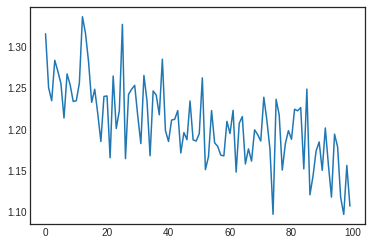

In [34]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure()
plt.plot(all_losses)
plt.show()

## 모델 테스트

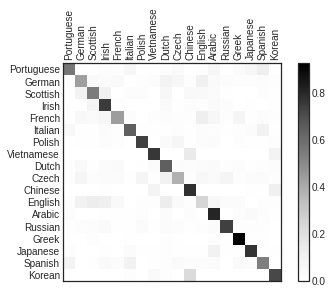

In [35]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 사용자 입력으로부터의 실행

In [40]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Jackson')
predict('Bill')
predict('Dovesky')
predict('Blain')


> Jackson
(-0.22) Scottish
(-2.27) English
(-3.01) Russian

> Bill
(-1.18) Irish
(-1.85) English
(-1.87) German

> Dovesky
(-0.19) Russian
(-2.21) Czech
(-3.50) English

> Blain
(-0.69) Irish
(-2.09) Scottish
(-2.32) Arabic
